In [1]:
import toml
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Optional
from binance.client import Client
from datetime import datetime, timezone

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams.update({'font.size': 18})

In [2]:
cfg = toml.load("configuration.toml")
pkey = cfg["auth"]["pkey"]
skey = cfg["auth"]["skey"]

client = Client(pkey, skey)

## Order Validation

All orders must obey certain rules called Filters (see https://github.com/binance/binance-spot-api-docs/blob/master/rest-api.md#filters). The function `client.get_exchange_info` returns a dictionary that has a list of dictionaries containing information each symbol in the exchange. After searching through the list for the desired dict of information (say for DOGEUSDT), you can retrieve the list of filters which must be obeyed.

Quick recap of the filters. This stuff can be skimmed, then reviewed as needed.

### Price Filter - min / max price
```
{
  "filterType": "PRICE_FILTER",
  "minPrice": "0.00000100",
  "maxPrice": "100000.00000000",
  "tickSize": "0.00000100"
}
```

- `minPrice <= price <= maxPrice`
- `(price - minPrice) % tickSize == 0`


### Percent Price - valid range for price based on prev. trades
```
{
  "filterType": "PERCENT_PRICE",
  "multiplierUp": "1.3000",
  "multiplierDown": "0.7000",
  "avgPriceMins": 5
}
```
- `multiplierDown * weightedAveragePrice <= price <= multiplierUp * weightedAveragePrice`
`weightedAveragePrice` from exchange info for that symbol

### Lot Size - min/max quantity
```
{
  "filterType": "LOT_SIZE",
  "minQty": "0.00100000",
  "maxQty": "100000.00000000",
  "stepSize": "0.00100000"
}
```
- `minQty <= quantity <= maxQty`
- `(quantity-minQty) % stepSize == 0`
If it is an Iceberg order, the quantity for each Iceberg order must satisfy this.

### Min Notional - min/max value
```
{
  "filterType": "MIN_NOTIONAL",
  "minNotional": "0.00100000",
  "applyToMarket": true,
  "avgPriceMins": 5
}
```
- `price * quantity > minNotional`

if `applyToMarket`, Market Orders also must obey this filter. Since market orders have no price, the average price is used over the last `avgPriceMinutes` mins, w/ `avgPriceMinutes == 0` implying that the last price will be used.

### Iceberg Parts - rule for breaking up big orders
```
{
  "filterType": "ICEBERG_PARTS",
  "limit": 10
}
```
Defines the maximum number of parts that an Iceberg Order can have. Number of `ICEBERG_PARTS` is `CEIL(qty / icebergQty)`.

### Market Lot Size - same as Lot size, but for Market Orders

### Max Num Orders - max orders that can be open on a symbol
```
{
  "filterType": "MAX_NUM_ORDERS",
  "maxNumOrders": 25
}
```
There is also `Max num algo orders`, `Max num iceberg orders`, `Exchange max num orders`, `Exchange max num algo orders`, all of which follow the same format.

### Max Position Filter - Defines the allowed max position an account can have on the base asset of a symbol
```
{
  "filterType":"MAX_POSITION",
  "maxPosition":"10.00000000"
}
```
Defined as sum of the account's
1. Free balance of base asset
2. Locked balance of base asset
3. Sum of the quantity of all open BUY orders


# Steps to execute buy/sell order

1. `get_exchange_info` and filter for the desired symbols to find the "Filters" for each symbol
2. Build order conforming to "Filters" for the desired symbol (depending on type of order? Since Market Orders execute instantly on the best possible open bid, we would probably want to go with those)
3. Execute order
4. Profit????

# Websocket trading

seems a bit more involved/nuanced, but 

In [3]:
exch_info = client.get_exchange_info()

def get_symbol_exchange_info(client: Client, symbol: str) -> Optional[Dict]:
    exchange_info = client.get_exchange_info()
    for symbol_data in exchange_info["symbols"]:
        if symbol_data["symbol"] == symbol:
            return symbol_data
    return None

get_symbol_exchange_info(client, "DOGEUSDT")

{'symbol': 'DOGEUSDT',
 'status': 'TRADING',
 'baseAsset': 'DOGE',
 'baseAssetPrecision': 8,
 'quoteAsset': 'USDT',
 'quotePrecision': 8,
 'quoteAssetPrecision': 8,
 'baseCommissionPrecision': 8,
 'quoteCommissionPrecision': 8,
 'orderTypes': ['LIMIT',
  'LIMIT_MAKER',
  'MARKET',
  'STOP_LOSS_LIMIT',
  'TAKE_PROFIT_LIMIT'],
 'icebergAllowed': True,
 'ocoAllowed': True,
 'quoteOrderQtyMarketAllowed': True,
 'isSpotTradingAllowed': True,
 'isMarginTradingAllowed': True,
 'filters': [{'filterType': 'PRICE_FILTER',
   'minPrice': '0.00000010',
   'maxPrice': '1000.00000000',
   'tickSize': '0.00000010'},
  {'filterType': 'PERCENT_PRICE',
   'multiplierUp': '5',
   'multiplierDown': '0.2',
   'avgPriceMins': 5},
  {'filterType': 'LOT_SIZE',
   'minQty': '1.00000000',
   'maxQty': '90000000.00000000',
   'stepSize': '1.00000000'},
  {'filterType': 'MIN_NOTIONAL',
   'minNotional': '10.00000000',
   'applyToMarket': True,
   'avgPriceMins': 5},
  {'filterType': 'ICEBERG_PARTS', 'limit': 10},

In [4]:
doge_usd_tick_data = client.get_ticker(symbol="DOGEUSDT")
bid_price = doge_usd_tick_data["lastPrice"]
quantity = 100

print(float(bid_price) * quantity)

min_quantity = f"{round(10.00000000 / float(bid_price) + 1):.8f}"
print(round(1 + 10.00000000 / float(bid_price)), min_quantity)

client.create_test_order(
    symbol="DOGEUSDT",
    side=client.SIDE_SELL,
    type=client.ORDER_TYPE_LIMIT,
    timeInForce=client.TIME_IN_FORCE_GTC,
    quantity=min_quantity,
    price=bid_price
)

5.9096
170 170.00000000


{}

# Data Mining

We want that sweet-sweet data. Best endpoint for that is `client.get_historical_trades(symbol="SYMBOL")`, which gives trades in chunks of 500 from some ID (default is most recent).

To get a big ol dataset of historical data,
1. run `historical_trades = client.get_historical_trades(symbol="SYMBOL")` and save the data
2. get minimum id by `min_id = historical_trades[0]["id"]`
3. `goto 1`, but this time include `id=min_id`

In [14]:
historical_trades = client.get_historical_trades(symbol="DOGEUSDT")

trade_ids = [trd["id"] for trd in historical_trades]

trade_times = [trd["time"] / 100 for trd in historical_trades]
trade_dts = [datetime.fromtimestamp(timestamp, timezone.utc) for timestamp in trade_times]

Text(0, 0.5, 'trade time')

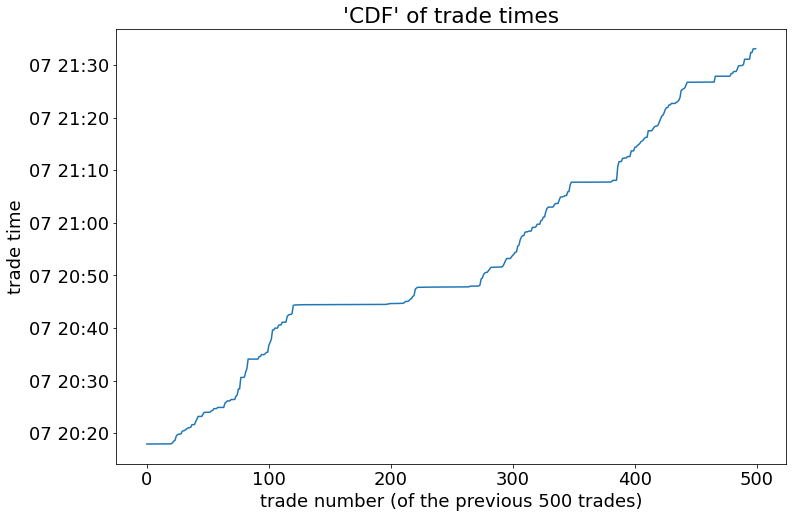

In [15]:
plt.plot(trade_dts)
plt.title("'CDF' of trade times")
plt.xlabel("trade number (of the previous 500 trades)")
plt.ylabel("trade time")

In [16]:
print(f"Max dt: {max(np.diff(trade_dts))}\nMin dt: {min(np.diff(trade_dts))}\nMean dt: {(max(trade_dts) - min(trade_dts)) / len(np.diff(trade_dts))}")  # say yes to calcualting the same thing 4 times pointlessly

Max dt: 0:02:35.539999
Min dt: 0:00:00
Mean dt: 0:00:09.039038


Text(0, 0.5, 'number of trades')

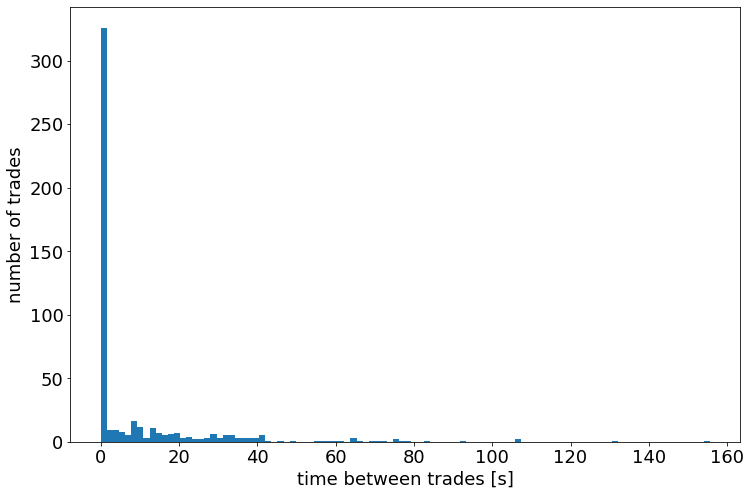

In [17]:
fs = [f.total_seconds() for f in np.diff(trade_dts)]
plt.hist(fs, bins=100)  # suppress unecessary output w/ the _ = ...
plt.xlabel(f"time between trades [s]")
plt.ylabel(f"number of trades")